# SARIMA

The goal of this notebook is fitting a SARIMA model,
$$ \Phi_P(B^P) \phi_p(B^s) \nabla_s^D \nabla^d X_t = \Theta_Q(B^s) \theta_p(B) Y_t$$

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [3]:
data = pd.read_parquet("../data/02_intermediate/summed_data.parquet")
data

,tsd,is_holiday,month,year
settlement_date,,,,
2009-01-01,1849363.0,1,1,2009
2009-01-02,1974406.0,0,1,2009
2009-01-03,1952054.0,0,1,2009
2009-01-04,1968670.0,0,1,2009
2009-01-05,2271471.0,0,1,2009
...,...,...,...,...
2023-04-21,1330791.0,0,4,2023
2023-04-22,1229948.0,0,4,2023
2023-04-23,1241704.0,0,4,2023


In [4]:
ts = pd.Series(data['tsd'])
ts

settlement_date
2009-01-01    1849363.0
2009-01-02    1974406.0
2009-01-03    1952054.0
2009-01-04    1968670.0
2009-01-05    2271471.0
                ...    
2023-04-21    1330791.0
2023-04-22    1229948.0
2023-04-23    1241704.0
2023-04-24    1392578.0
2023-04-25    1358610.0
Name: tsd, Length: 5228, dtype: float64

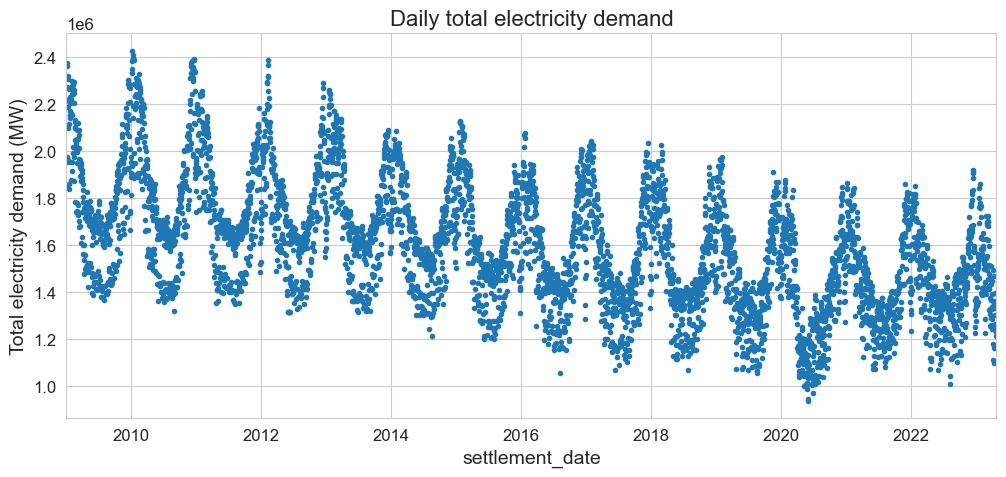

In [5]:
ts.plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

## Calculate de parameters for the model 

### Tune the model
We build a SARIMA model to represent the time series. SARIMA is an acronym for Seasonal AutoRegressive Integrated Moving Average. It is composed of two models AR and MA. The model is defined by three parameters:

* $d =$ degree of first differencing involved
* $p =$ order of the AR part
* $q =$ order of the moving average part.

The value of $p$ can be determined through the ACF plot, which shows the autocorrelations which measure the relationship between an observation and its previous one. The value of $d$ is the order of integration and can be calculated as the number of transformations needed to make the time series stationary. The value of $q$ can be determined through the PACF plot.

#### Finding d

In order determine the value of $d$, we can perform the _Dickey-Fuller test_, which is able to verify whether a time series is stationary or not. We can use the `adfuller` class, contained in the `statsmodels` library. We define a function, called `test_stationarity()`, which returns True, if the time series is positive, False otherwise.

In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC') # apply the test
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3 # alpha = 0.05 ??
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False

In [7]:
test_stationarity(ts)

X is not stationary


False

We have checked that the series is not stationary. We transform the time series through the `diff()` function as many times as the time series becomes stationary.

In [8]:
ts_diff = pd.Series(ts)
d = 0
while test_stationarity(ts_diff) is False:
    ts_diff = ts_diff.diff().dropna()
    d = d + 1

X is not stationary
X is stationary


After applying one time the differencing operator, we obtain a stationary time series.

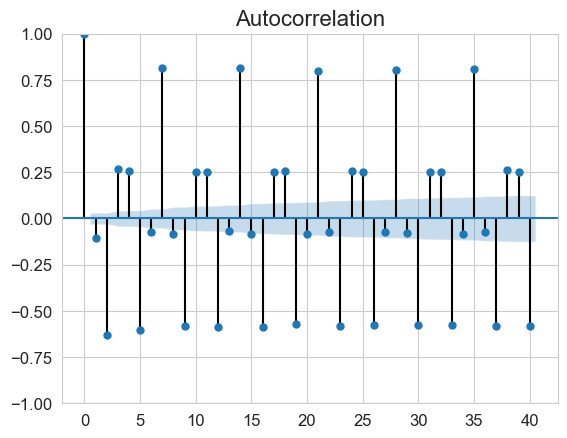

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_diff, lags =40)
plt.show()

#### Finding D

The $(P,D,Q,s)$ Order refers to the seasonal component of the model for the Auto Regressive parameters, differences, Moving Average parameters, and periodicity:

* $D$ indicates the integration order of the seasonal process (the number of transformation needed to make stationary the time series)
* $P$ indicates the Auto Regressive order for the seasonal component
* $Q$ indicated the Moving Average order for the seasonal component
* $s$ indicates the periodicity, i.e. the number of periods in season, such as 12 for monthly data.

In order to evaluate the seasonal order, we must extract the seasonal component from the time series. For this reason, we exploit the `seasonal_decompose()` function provided by the `statsmodels` library. Among the input parameters, we can specify the decomposition model (additive or multiplicative) and if we want to extrapolate the trend or not. The function returns the trend, the seasonal and the resid components.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_diff, model='additive',extrapolate_trend='freq')

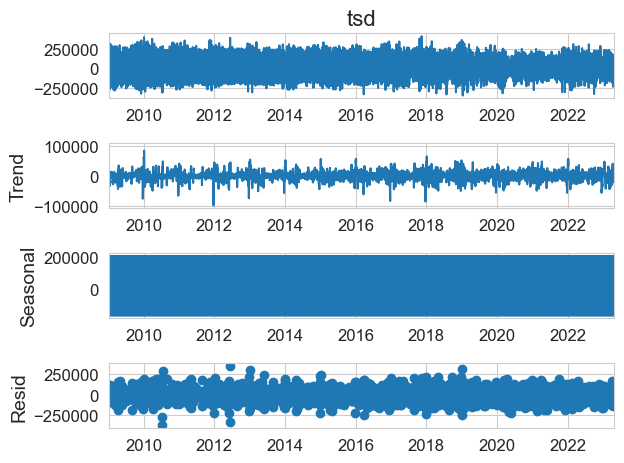

In [10]:
result.plot()
plt.show()

In [11]:
seasonal = result.seasonal
test_stationarity(seasonal)

X is stationary


True

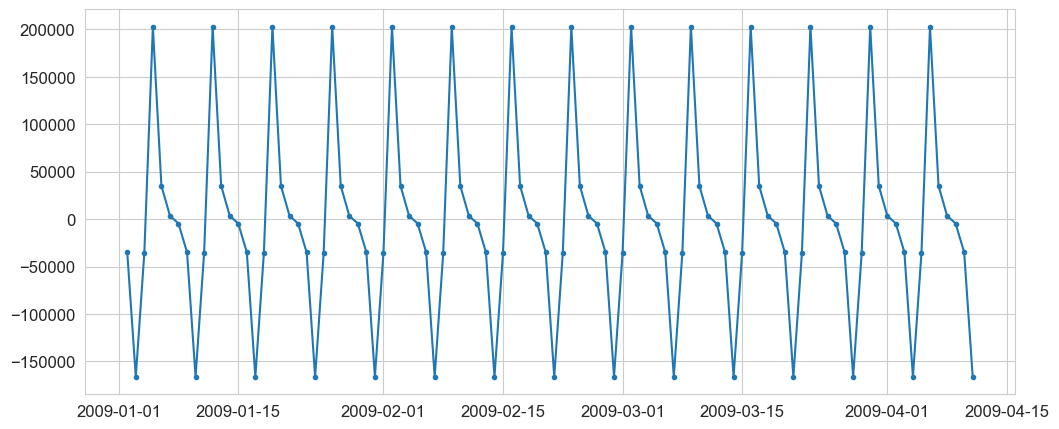

In [12]:
plt.figure(figsize=(12,5))
plt.plot(seasonal[:100], '.-')

mirar como funciona la función `diff()` y ver cuantas veces es necesario aplicarla para quitar la componente estacional


In [19]:
ts_diff_s = pd.Series(ts_diff)
ts_diff = ts_diff.diff(365.25).dropna()


In [14]:
result2 = seasonal_decompose(ts_diff_s, model='additive',extrapolate_trend='freq')

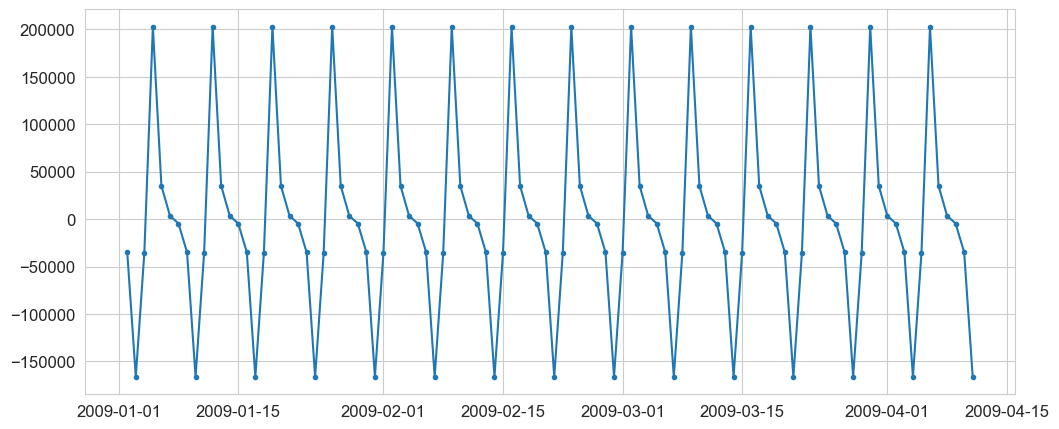

In [15]:
plt.figure(figsize=(12,5))
plt.plot(result2.seasonal[:100], '.-')

In order to calculate the value of $p$ and $q$, we can plot the ACF and PACF graphs, respectively. We can use the `plot_acf()` and `plot_pacf()` functions available in the statsmodels library. The value of $p$ corresponds to the maximum value in the ACF graph external to the confidence intervals (shown in light blue). In our case, the correct value of $p = 9$.

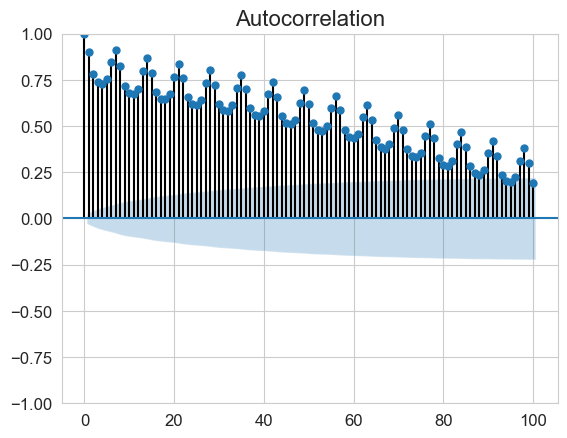

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =100)
# plt.savefig('plots/acf.png')
plt.show()